In [14]:
import torch
from SPN import SPN
from matplotlib import pyplot as plt
import utils
from torchinfo import summary
import numpy as np
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO 
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
from pathlib import Path
from Anneal import anneal
import pickle
import time
import GD

### Initialize an FLPO scenario

Run the below command if you encounter errors running the plotting block.

In [2]:
# !pip install nbformat --upgrade

Running on:  cpu
num_drones = 10	 num_facilities = 4	 dim = 2	 num_distinct_ends = 2


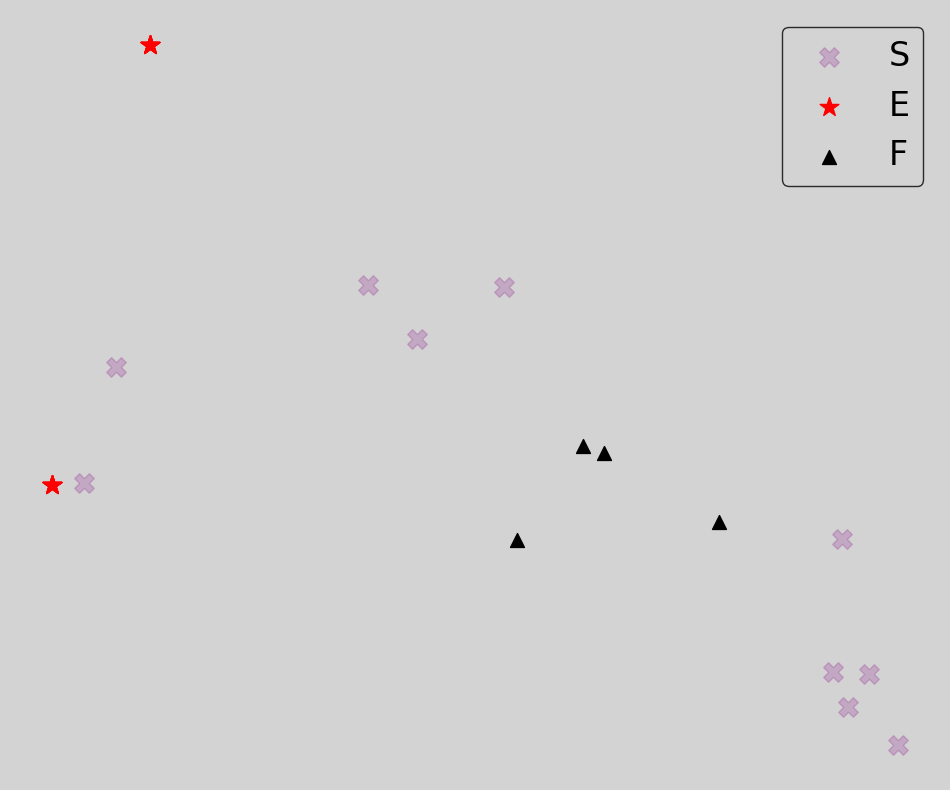

In [16]:
seed=3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
load_from_path = True
scene_path = "Benchmark/benchmark_data/N10_M4_ends2_seed3"
print("Running on: " , device)

if load_from_path:
    with open(scene_path, 'rb') as file:
        data = pickle.load(file)
    START_locs = data["START_locs"]
    F_base = data["F_base"]
    END_locs = data["END_locs"]
    num_drones = START_locs.shape[0]
    num_facilities = F_base.shape[-2]
    dim_ = F_base.shape[-1]
    num_distinct_ends = len(torch.unique(END_locs, dim=0))
    print(f"num_drones = {num_drones}\t num_facilities = {num_facilities}\t dim = {dim_}\t num_distinct_ends = {num_distinct_ends}")
    assert(F_base.requires_grad == True)
else:
    num_drones = 10
    n_drone_clusters = 3
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    num_facilities = 4
    num_distinct_ends = 2
    dim_ = 2
    print(f"num_drones = {num_drones}\t num_facilities = {num_facilities}\t dim = {dim_}\t num_distinct_ends = {num_distinct_ends}")
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        num_facilities, 
        dim_, 
        device, 
        seed,
        drone_cluster_std_range=[0.02, 0.03], 
        F_noise_std=0.05,
        num_distinct_ends=num_distinct_ends
    )
    assert(F_base.requires_grad == True)

start_locs_np = START_locs.cpu().numpy().reshape(-1,2)
end_locs_np = END_locs.cpu().numpy().reshape(-1,2)
fac_locs = F_base.detach().cpu().numpy().squeeze()

plot_UAV_FLPO(START_locs, END_locs, F_base, (12,10))
# # plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Save a new scenario

In [8]:
# benchmark_data = {
#     "START_locs":START_locs, 
#     "F_base":F_base, 
#     "END_locs":END_locs,
# }

# scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
# filepath = "Benchmark/benchmark_data/" + scenario
# print(filepath)

# with open(filepath, 'wb') as file:
#     pickle.dump(benchmark_data, file)

Benchmark/benchmark_data/N10_M4_ends2_seed3


### Load the SPN Module

In [17]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path("Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
print("SPN loaded on: ", spn.device)
print(summary(spn))

Model created.
SPN loaded on:  cpu
Layer (type:depth-idx)                                       Param #
SPN                                                          --
├─LinearAttnEncoder: 1-1                                     2,048
│    └─ModuleList: 2-1                                       --
│    │    └─MultiheadAttention: 3-1                          (66,048)
│    │    └─MultiheadAttention: 3-2                          (66,048)
│    │    └─MultiheadAttention: 3-3                          (66,048)
│    │    └─MultiheadAttention: 3-4                          (66,048)
│    │    └─MultiheadAttention: 3-5                          (66,048)
│    │    └─MultiheadAttention: 3-6                          (66,048)
│    └─ModuleList: 2-2                                       --
│    │    └─MultiheadAttention: 3-7                          (66,048)
│    │    └─MultiheadAttention: 3-8                          (66,048)
│    │    └─MultiheadAttention: 3-9                          (66,048)
│    │ 

### Optimization loop for a single beta


In [29]:
optim_iters = 200
optim_step = 0.01
b_min = 1e4
beta = 1e4
tol = 1e-3

Y_arr_adam, FreeEnergy_adam, G_adam = GD.Adam_at_beta(
    F_base, START_locs, END_locs, spn, optim_iters,
    optim_step, tol=tol, allowPrint=True, return_list= True)


iter: 0	FreeE: 1.1177e-01	Norm gradient: 0.260	mean_D_min:1.118e-01
iter: 1	FreeE: 1.0624e-01	Norm gradient: 0.223	mean_D_min:1.062e-01
iter: 2	FreeE: 1.0195e-01	Norm gradient: 0.189	mean_D_min:1.020e-01
iter: 3	FreeE: 9.7137e-02	Norm gradient: 0.196	mean_D_min:9.714e-02
iter: 4	FreeE: 9.5338e-02	Norm gradient: 0.171	mean_D_min:9.534e-02
iter: 5	FreeE: 9.2955e-02	Norm gradient: 0.154	mean_D_min:9.296e-02
iter: 6	FreeE: 9.0896e-02	Norm gradient: 0.142	mean_D_min:9.090e-02
iter: 7	FreeE: 8.9035e-02	Norm gradient: 0.131	mean_D_min:8.904e-02
iter: 8	FreeE: 8.7306e-02	Norm gradient: 0.122	mean_D_min:8.731e-02
iter: 9	FreeE: 8.4310e-02	Norm gradient: 0.144	mean_D_min:8.431e-02
iter: 10	FreeE: 8.1849e-02	Norm gradient: 0.158	mean_D_min:8.185e-02
iter: 11	FreeE: 7.8842e-02	Norm gradient: 0.179	mean_D_min:7.884e-02
iter: 12	FreeE: 7.6539e-02	Norm gradient: 0.179	mean_D_min:7.654e-02
iter: 13	FreeE: 7.3781e-02	Norm gradient: 0.234	mean_D_min:7.378e-02
iter: 14	FreeE: 7.1622e-02	Norm gradient: 0.

### Using SPN and Path Sampling

In [28]:
# optim_iters = 500
# optim_step = 0.01
# b_min = 100
# beta = 1e3
# tol = 0.001
# n_path_samples = 8

# tic = time.time()
# F_base0_highbeta = F_base.clone().detach().requires_grad_(True)
# F_base_sampling, FreeEnergy_sampling, G_sampling = GD.sampling_GD_at_beta_auto_diff(
#     F_base0_highbeta,
#     START_locs,
#     END_locs,
#     spn,
#     n_path_samples=n_path_samples,
#     beta=beta,
#     stepsize=optim_step,
#     iters=optim_iters,
#     tol=tol,
#     allowPrint=True
#     )
# toc = time.time()
# runtime_high_beta = toc-tic


TypeError: Adam_at_beta() got an unexpected keyword argument 'n_path_samples'

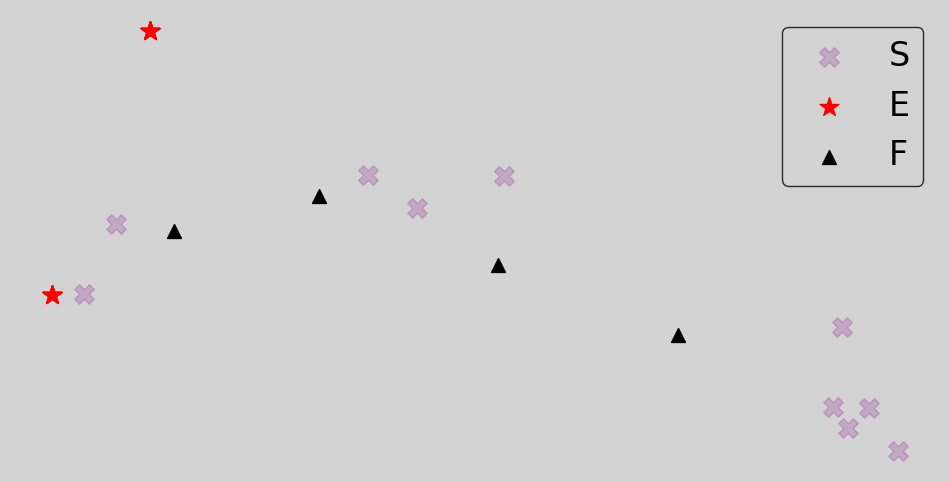

In [19]:
plot_UAV_FLPO(START_locs, END_locs, F_base_sampling, (12,6))


### Save the high beta results (plotting done in plot_res.ipynb)

In [31]:
# scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
# file_path0 = "AAAI26_res/high_beta_res/" + scenario
# print(file_path0)
# # file_path0 = "AAAI26_res/low_beta_res/" + scenario

# high_beta_res_data = {
#     "START_locs":START_locs,
#     "END_locs":END_locs,
#     "F_base":F_base_sampling,
#     "n_ends":num_distinct_ends,
#     "F_base0":F_base0_highbeta,
#     "optim_method":"sampling_GD_at_beta_auto_diff",
#     "optim_iters":optim_iters,
#     "optim_step":optim_step,
#     "beta":beta,
#     "optim_tol":tol,
#     "n_path_samples":n_path_samples,
#     "Free_energy_final":FreeEnergy_sampling,
#     "Gradient_final":G_sampling,
#     "runtime":runtime_high_beta
# }

# with open(file_path0, 'wb') as file:
#     pickle.dump(high_beta_res_data, file)

AAAI26_res/high_beta_res/N100_M5_ends4_seed3


### Annealing loop implementation
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

beta: 1.0000e-03	FreeE: -2564.7876	Grad: 5.8863e-02
beta: 1.0000e-02	FreeE: -256.3289	Grad: 5.5919e-02
beta: 1.0000e-01	FreeE: -25.4830	Grad: 5.6654e-02
beta: 1.0000e+00	FreeE: -2.4101	Grad: 3.3885e-02
beta: 1.0000e+01	FreeE: -0.1228	Grad: 5.7322e-02
beta: 1.0000e+02	FreeE: 0.0515	Grad: 4.1373e-02
beta: 1.0000e+03	FreeE: 0.0565	Grad: 4.3816e-02
beta: 1.0000e+04	FreeE: 0.0577	Grad: 2.2075e-02


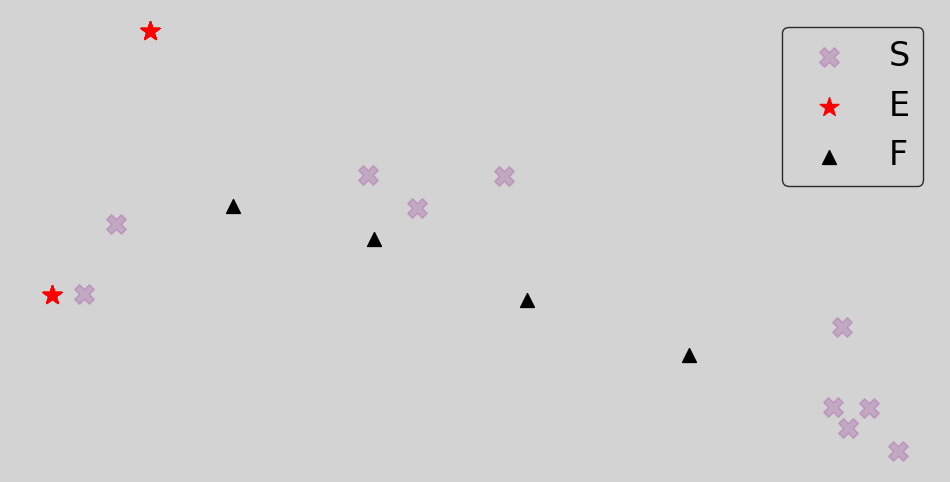

In [26]:
beta_min = 1e-3 
beta_max = 1e4
beta_grow = 10
optim_iters = 100
optim_step = 0.01 # 0.1 for gd0, sampling_gd, use < 0.01 for the other two optimizers 
optim_name = "sampling_auto_diff"
tol = 0.001
n_path_samples = 8

tic = time.time()
F_base0_anneal = F_base.clone().detach().requires_grad_(True)
Y_arr, b_arr, F_arr = anneal( 
        F_base0_anneal, 
        START_locs, 
        END_locs, 
        spn,  
        optim_iters, 
        optim_step, 
        beta_min, 
        beta_max, 
        beta_grow, 
        tol=tol, 
        optimizer_name=optim_name, 
        n_path_samples=n_path_samples, 
        allowPrint=True 
    ) 
toc = time.time()
runtime_anneal = toc-tic 
plot_UAV_FLPO(START_locs, END_locs, Y_arr[-1], (12,6)) 


### Save the annealing results (plotting done in plot_res.ipynb)

In [33]:
# file_path1 = "AAAI26_res/annealing_res/" + scenario
# print(f'filepath: {file_path1}')

# annealing_res_data = {
#     "START_locs":START_locs,
#     "END_locs":END_locs,
#     "Y_arr":Y_arr,
#     "b_arr":b_arr,
#     "F_arr":F_arr,
#     "F_bas0":F_base0_anneal,
#     "optim_method":optim_name,
#     "optim_iters":optim_iters,
#     "optim_step":optim_step,
#     "optim_tol":tol,
#     "n_path_samples":n_path_samples,
#     "runtime":runtime_anneal
# }

# with open(file_path1, 'wb') as file:
#     pickle.dump(annealing_res_data, file)

filepath: AAAI26_res/annealing_res/N100_M5_ends4_seed3


### Animation results moved to plot_res.ipynb